# Model C: Using a Pipeline with simple imputer

Importing libraries we will use, nump,y pandas, scikit-learn models and metrics, etc...

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import warnings
warnings.simplefilter(action='ignore')

seed = 42
np.random.seed(seed)

In [2]:
# We will use these metrics to check our model performance

metrics = [
    ('Precision', precision_score, False),
    ('Recall', recall_score, False),
#     ('MCC', matthews_corrcoef, False),
#     ('F1', f1_score, False),
     ('ROC-AUC', roc_auc_score, True)
]

## Load dataset

Load data from Google Cloud Storage.

In [3]:
# train = pd.read_csv('gs://home-credit-simonyi-workshop/input/application_train.subsample.csv')
train = pd.read_csv('input/application_train.csv')

train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Let's use some new fields: **EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3**

In [4]:
target = 'TARGET'

features = [
    'DAYS_EMPLOYED',
    'DAYS_BIRTH',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'CNT_FAM_MEMBERS',
    'AMT_ANNUITY',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
]

for f in features:
    train.loc[train[f] == np.inf, f] = np.nan

X = train.loc[:, features]
y = train.loc[:, target]

print("Train features DataFrame shape:", X.shape)
print("Train target Series shape:", y.shape)

Train features DataFrame shape: (307511, 9)
Train target Series shape: (307511,)


## Train-test split

We are splitting out dataset into **train** and **validate** sets. We will use the train dataset to train our models, and the validate dataset, to check our results. 

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, stratify=train[target], random_state=seed)

print('Train features shape: ', X_train.shape)
print('Train target shape: ', y_train.shape)
print('Validate features shape: ', X_valid.shape)
print('Validate target shape: ', y_valid.shape)

Train features shape:  (153755, 9)
Train target shape:  (153755,)
Validate features shape:  (153756, 9)
Validate target shape:  (153756,)


## Create the pipeline.

We use RandomForestClassifier as our model.

In [6]:
ct = ColumnTransformer([
    ("impute", SimpleImputer(missing_values=np.nan, strategy='mean'), list(range(0, 8))),
])

model = Pipeline(steps=[
    ('imputer', ct),
    ('random_forest', RandomForestClassifier(n_estimators=10, random_state=seed))
])

Let's try to access SimpleImputer statistics, before we fit our model. It should not work.

In [7]:
try:
    print('Simple imputer statistics:')
    print(model['imputer'].named_transformers_['impute'].statistics_)
except:
    print('Not available before training.')
    pass

Simple imputer statistics:
Not available before training.


## Train the model (pipeline)

In [8]:
model.fit(X_train, y_train);

Let's have another try to access the SimpleImputer statistics. Now they are available.

In [9]:
try:
    print('Simple imputer statistics:')
    print(model['imputer'].named_transformers_['impute'].statistics_)
except:
    print('Statistics are not available before training')
    pass

Simple imputer statistics:
[ 6.37595908e+04 -1.60261914e+04  1.69570705e+05  6.00047564e+05
  2.15480472e+00  2.71612285e+04  5.00909139e-01  5.15195697e-01]


Check prediction performance on train dataset.

In [10]:
pred_train = model.predict(X_train)
proba_train = model.predict_proba(X_train)[:,1]

for m in metrics:
    score = m[1](y_train, proba_train) if m[2] else m[1](y_train, pred_train)
    print('%s on train: %.3f' % (m[0], score))

Precision on train: 1.000
Recall on train: 0.807
ROC-AUC on train: 1.000


Of course it is close to perfect, but this is expected. But let's check out model on new data!

## Evaluate model

In [11]:
pred_valid = model.predict(X_valid)
proba_valid = model.predict_proba(X_valid)[:,1]

In [12]:
for m in metrics:
    score = m[1](y_valid, proba_valid) if m[2] else m[1](y_valid, pred_valid)
    print('%s on CV: %.3f' % (m[0], score))

Precision on CV: 0.285
Recall on CV: 0.014
ROC-AUC on CV: 0.610


## Visualize precision-recall tradeoff

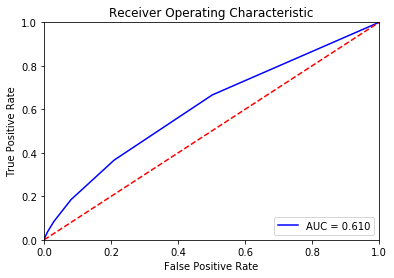

In [13]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_valid)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()